In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from grl.utils.data import uncompress_episode_rewards

from definitions import ROOT_DIR

In [2]:
results_dir_td = Path(ROOT_DIR, 'results', 'rnn_reruns_td')
results_dir_mc = Path(ROOT_DIR, 'results', 'rnn_reruns_mc')
results_dir_split = Path(ROOT_DIR, 'results', 'rnn_split')

In [3]:

offline_eval = []
all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())
# all_results_paths = list(results_dir_split.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = info['args']
    
    if (args['multihead_loss_mode'] != 'both') and (args['multihead_lambda_coeff'] > 0.):
        continue

    offline_evals = info['episodes_info']['offline_eval']
    eval_freq = args['offline_eval_freq']
    total_steps = args['total_steps']
    
    all_t_undisc_returns = []
    for i, oe in enumerate(offline_evals):
        d = {**args}
        
        avg_undisc_returns = 0
        for ep in oe['episode_rewards']:
            episode_rewards = np.array(uncompress_episode_rewards(ep['episode_length'], ep['most_common_reward'], ep['compressed_rewards']))

            # TODO: calculate value estimation error through q_t - g_t
            undisc_returns = episode_rewards.sum()
            avg_undisc_returns += undisc_returns

        avg_undisc_returns /= len(oe['episode_rewards'])
        d['timestep'] = int(i * eval_freq)
        d['undisc_returns'] = undisc_returns
    
        offline_eval.append(d)

all_res_df = pd.DataFrame(offline_eval)

  0%|          | 0/1920 [00:00<?, ?it/s]

In [24]:
arch = "lstm"
offline_eval_df = all_res_df[
    (all_res_df['arch'] == arch) & 
    (all_res_df['multihead_lambda_coeff'] >= 0.)
]

unique_seeds = offline_eval_df.seed.unique()

split_by_args = ['spec', 'multihead_action_mode', 'multihead_loss_mode', 'multihead_lambda_coeff', 'timestep']
rnn_grouped = offline_eval_df.groupby(split_by_args, as_index=False)

In [25]:
# take mean and std_err over mean over seeds
rnn_mean = rnn_grouped.mean(numeric_only=True)
rnn_sem = rnn_grouped.sem(numeric_only=True)


In [26]:
all_labels = \
    sorted(['_'.join([str(el) for el in row]) for row in offline_eval_df[[arg for arg in split_by_args if (arg != 'spec') and (arg != 'timestep')]]\
        .drop_duplicates()\
        .to_numpy()])

label_cmap = {}

color = iter(cm.tab10(np.linspace(0, 1, 10)))
for i in range(len(all_labels)):
    c = next(color)
    label_cmap[all_labels[i]] = c

  0%|          | 0/8 [00:00<?, ?it/s]

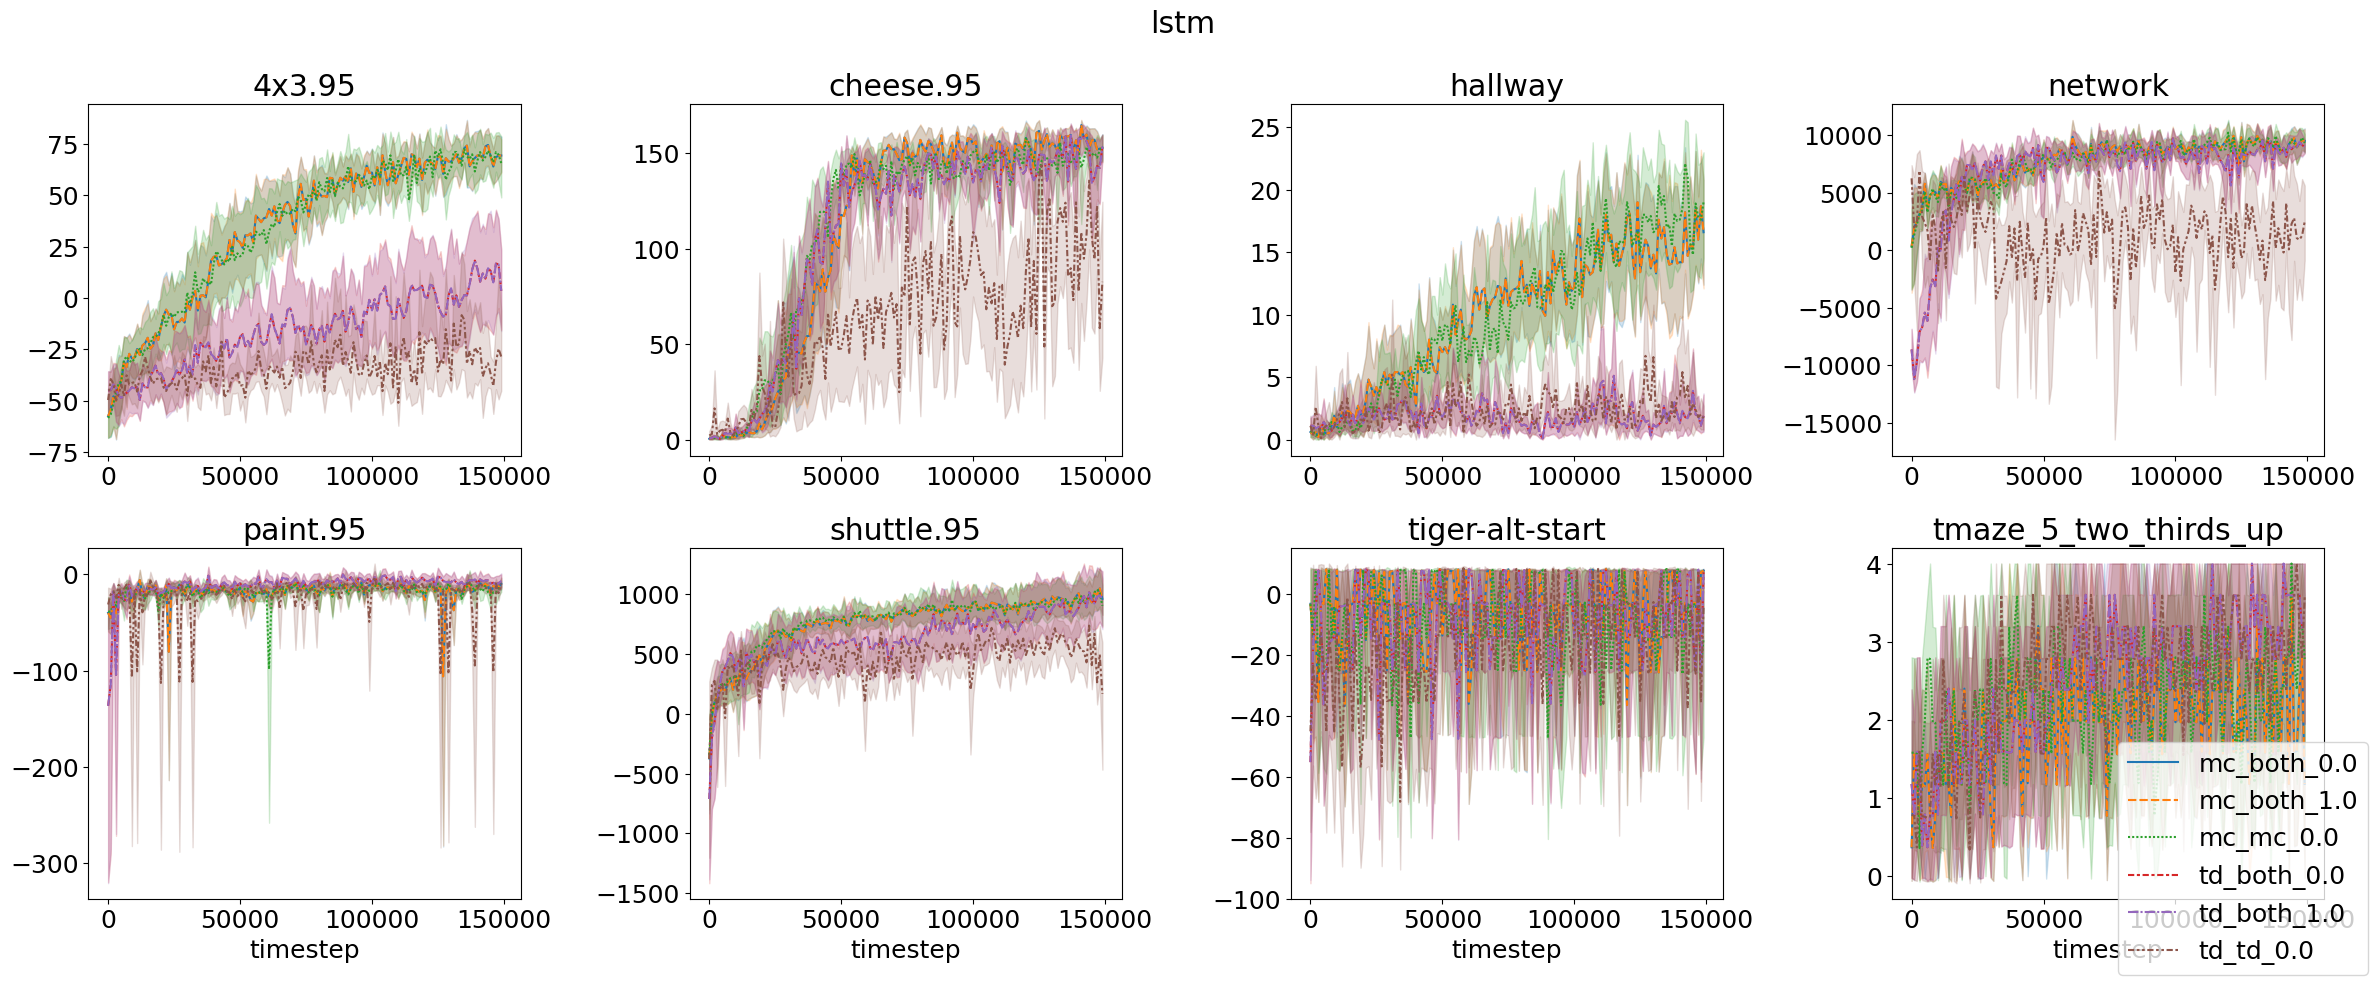

In [27]:
df = offline_eval_df
pivot_value_key = 'undisc_returns'

spec_strs = df['spec'].unique()

pivot_cols = [arg for arg in split_by_args if (arg != 'spec') and (arg != 'timestep')] + ['seed']

n_rows, n_cols = 2, np.ceil(len(spec_strs) / 2).astype(int)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 10))

for i, spec in tqdm(list(enumerate(sorted(spec_strs)))):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    spec_df = df[df['spec'] == spec]
    sorted_spec_df = spec_df.sort_values(by=split_by_args)
    
    # Make a pivot table
    pivot_df = sorted_spec_df.pivot(index='timestep', columns=pivot_cols, values=pivot_value_key)
    
    # Flatten all columns except seed
    col_name = '_'.join([col for col in pivot_cols if col != 'seed'])
    multi_index = pd.MultiIndex.from_tuples([('_'.join([str(c) for c in col[:-1]]), col[-1]) for col in pivot_df.columns], names=[col_name, "seed"])

    pivot_df.columns = multi_index

    sns.lineplot(ax=ax, data=pivot_df, palette=label_cmap)
    
    ax.get_legend().remove()
    ax.set_title(spec)
    if col > 0:
        ax.set_ylabel(None)
    if row < n_rows - 1:
        ax.set_xlabel(None)
        
    handles, labels = ax.get_legend_handles_labels()
    
#     if i >= 1:
#         break
        
fig.legend(handles, labels, loc='lower right')
fig.suptitle(arch)
fig.tight_layout()

In [28]:
fig_path = Path(ROOT_DIR, 'results', f'{arch}_rnn_reruns.pdf')
fig.savefig(fig_path, bbox_inches='tight')

In [ ]:
all_results_paths = list(results_dir_td.iterdir()) + list(results_dir_mc.iterdir())
# all_results_paths = list(results_dir_split.iterdir())

for results_path in tqdm(all_results_paths):
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    
    info = load_info(results_path)
    args = info['args']
    
    if args['multihead_lambda_coeff'] == 1.:
        print(results_path)

  0%|          | 0/1920 [00:00<?, ?it/s]

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2027)_time(20230605-230535)_59f9e98443538020f88170dd579a2dc0.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/cheese.95_seed(2022)_time(20230605-224740)_dfc7d624fa67797f2887716ef94a8a24.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/network_seed(2026)_time(20230605-225956)_6f64d43bcafcc552b652e3796a9784c8.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tiger-alt-start_seed(2025)_time(20230605-225703)_1aa7cbc85c3bf6b705d5cab5a0d60fe7.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2024)_time(20230605-232010)_0e135bf0535ccffcca3a96b3201a29fc.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2026)_time(20230605-231412)_11f2e815144fda4a1a2ca5123180f345.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tiger-alt-start_seed(2028)_time(20230605-225551)_c72429c4c75995606ab86f973aa9c35d.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/pa

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/network_seed(2023)_time(20230605-225930)_bb2d123149527b6d09d4b28b675b1644.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2024)_time(20230605-231144)_057f5b730727e8d50b1e31d315cd1bfa.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2028)_time(20230605-232330)_011e03aa54937c20c178513f3c347942.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2020)_time(20230605-230329)_be638146fffecb5d6f02940a5d0d4385.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2022)_time(20230605-230516)_2afc49dcad3b0a10ac37a658cfa015f2.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2020)_time(20230605-230752)_af69265f4ebc4c6a7ab2b8b8070ab020.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2022)_time(20230605-230351)_736b38634ce34554d70bf99a63db01ca.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2021)_time(20

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2020)_time(20230605-224737)_de8c294e88ba8326d6be78c5f8a8b2e8.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2026)_time(20230605-230440)_17a901f76c7c543b50dfbe035ae9dca3.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tiger-alt-start_seed(2026)_time(20230605-225703)_8d3367db2d5d9f724a1c169bb07778b6.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/network_seed(2025)_time(20230605-230518)_c1c91b95a858dcc74ff786674cfd36eb.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2027)_time(20230605-230102)_ca580df6bf4729aedf55fe9d9f45dac6.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2021)_time(20230605-224739)_39fd4d5ad6cf606d86c9018d5c23d02c.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2023)_time(20230605-232536)_422ba1e6fa9d752847fa4a3a1988d380.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tiger-alt-start_seed(2023)_

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2021)_time(20230605-224740)_0368b4bdccbf33dfb64779125364b093.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2026)_time(20230605-232312)_1020b0eed2e36b3b9c7df9e4dec1cd46.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2029)_time(20230605-232403)_ceb954539f87711e88df62290a12e128.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/cheese.95_seed(2028)_time(20230605-230307)_c5802254663d8c4b96fcb203d713e5ff.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2025)_time(20230605-230135)_7cf8076675639b6593cc176ad52ca054.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2027)_time(20230605-230604)_ddf83390111b3fd5eed1c6a471cda03c.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2023)_time(20230605-231720)_24d007bbbc421f15e1318e1d42984fbe.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallw

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2024)_time(20230605-230229)_4e8ab60797aba82e0a72c9346789b4c5.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2024)_time(20230605-224740)_d245452227b6f19f45a99c2c42b0c03c.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2023)_time(20230605-230330)_bcd0847103111de377304c71a0f86e23.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2024)_time(20230605-230216)_3f28e2604f1241fcbde33ef5558f02b8.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/network_seed(2020)_time(20230605-230005)_17c48b885cea799e1a299e5d182ae20f.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/network_seed(2020)_time(20230605-230413)_d98afeaf87a54bccfec251898aa8ca27.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2025)_time(20230605-231526)_8b7186467440bd8cc5eb3d6b4860c443.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/hallway_seed(2025

/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/shuttle.95_seed(2029)_time(20230605-230306)_0c717095fc0111d7ec37ae183fd10698.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tiger-alt-start_seed(2021)_time(20230605-230858)_1fcb44ec9b663294a38978f4b434c770.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/4x3.95_seed(2026)_time(20230605-231212)_f5175b42bc7488a8e297b2da87c558c9.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/tmaze_5_two_thirds_up_seed(2029)_time(20230605-224740)_77eb585292894abaf94fab4d6bd61acc.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_td/paint.95_seed(2020)_time(20230605-230031)_228d01a9ecccd7970f8910af225110dd.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/hallway_seed(2023)_time(20230605-233926)_f397b42369e963347a647ae33536211a.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tiger-alt-start_seed(2026)_time(20230605-233927)_2d6fff724c3d3b22dd35ca4724f9161e.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/chees

/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/paint.95_seed(2024)_time(20230605-232426)_d70198cd83240bb0f175214f1459a02a.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/network_seed(2021)_time(20230605-231459)_51399931bf9643fb2d3bc20fb746555d.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/shuttle.95_seed(2023)_time(20230605-235607)_d4808e397cca607cf43de9af7cf037fd.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/shuttle.95_seed(2025)_time(20230605-232638)_6431e4993c2ce60f692cf6e7d13339b8.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/cheese.95_seed(2024)_time(20230605-232417)_2f45a5e3481adec8708964a4ddc5011f.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/hallway_seed(2026)_time(20230605-232954)_fd4bbca24b12f6a70821df79de7df49d.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/hallway_seed(2023)_time(20230605-234653)_3303caed34565193ce2df6cda6262c3e.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/hallway_seed(2025)_time(20230

/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/cheese.95_seed(2023)_time(20230605-232223)_4c1a03fe1fec4465d355235152a9dd0f.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/hallway_seed(2021)_time(20230605-231529)_30582ed9a9d73add9089e34ff6fc6b24.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/4x3.95_seed(2023)_time(20230605-234547)_b0ac1d39b41ce8af2b1dcb5fe1192218.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tmaze_5_two_thirds_up_seed(2027)_time(20230606-000724)_164e010c9e3b04d38b65c0c0a40c7b8d.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tmaze_5_two_thirds_up_seed(2027)_time(20230605-234532)_35de40f7ec0aaead3a7610713d53ee7e.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/shuttle.95_seed(2023)_time(20230605-233421)_2f6a8c96b75bdaa2b261bfe294d8a9f2.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tiger-alt-start_seed(2021)_time(20230605-231502)_8958b8e7f07c04e8a394b4f4899081e2.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_m

/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/4x3.95_seed(2029)_time(20230606-001436)_71f7e9dc1a531b7992104b96dc83ccaa.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/4x3.95_seed(2024)_time(20230605-232439)_178ea01ba06d8233853b2625cc45cd67.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tmaze_5_two_thirds_up_seed(2023)_time(20230605-233748)_433155e746c4e7a032cb98eef4ceb10f.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tiger-alt-start_seed(2022)_time(20230605-234132)_99c17355aed16e87d7f1bb74ac60f589.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/4x3.95_seed(2022)_time(20230605-233422)_09181f3d1efd5ba650ddf4fe836efd12.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/network_seed(2028)_time(20230605-233641)_b2ef1b0e4cef2dd1dd70859ab0fbf978.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/paint.95_seed(2021)_time(20230605-232700)_c10232c93545360f51d644e0a34f7e5e.npy
/Users/ruoyutao/Documents/grl/results/rnn_reruns_mc/tmaze_5_two_thirds